In [37]:
import numpy as np
import psutil
import os

In [38]:
n = 2

In [39]:
zero = np.array([1, 0], dtype=complex)
one = np.array([0, 1], dtype=complex)

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                  [1, -1]], dtype=complex)

I = np.array(
    [[1,0],
     [0,1]]
)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)

Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

def Rx(theta):
    cos = np.cos(theta / 2)
    isin = -1j * np.sin(theta / 2)
    return np.array([[cos, isin],
                     [isin, cos]], dtype=complex)

def Rz(theta):
    exp_plus = np.exp(-1j * theta / 2)
    exp_minus = np.exp(1j * theta / 2)
    return np.array([[exp_plus, 0],
                     [0, exp_minus]], dtype=complex)

def Rzz(theta):
    exp_00 = np.exp(-1j * theta / 2)
    exp_11 = np.exp(-1j * theta / 2)
    exp_01 = np.exp(1j * theta / 2)
    exp_10 = np.exp(1j * theta / 2)

    RZZ = np.array([[exp_00, 0,      0,      0],
                    [0,      exp_01, 0,      0],
                    [0,      0,      exp_10, 0],
                    [0,      0,      0,      exp_11]], dtype=complex)
    return RZZ

In [40]:
def initialize_state(n, state_vector=None):
    if state_vector is not None:
        if len(state_vector) != 2**n:
            raise ValueError("State vector length does not match number of qubits.")
        state = state_vector.reshape([2]*n)
    else:
        state = zero
        for _ in range(n - 1):
            state = np.tensordot(state, zero, axes=0)
    return state

def apply_single_qubit_gate(state, gate, target):
    n_qubits = state.ndim
    state = np.moveaxis(state, target, 0)
    state = np.tensordot(gate, state, axes=([1], [0]))
    state = np.moveaxis(state, 0, target)
    return state

def apply_two_qubit_gate(state, gate, qubit1, qubit2):
    n_qubits = state.ndim
    permute_order = [qubit1, qubit2] + [i for i in range(n_qubits) if i != qubit1 and i != qubit2]
    state = np.transpose(state, permute_order)
    original_shape = state.shape
    state = state.reshape(4, -1)
    state = np.tensordot(gate, state, axes=([1], [0]))
    state = state.reshape([2, 2] + list(original_shape[2:]))
    inverse_permute_order = np.argsort(permute_order)
    state = np.transpose(state, inverse_permute_order)
    return state

def apply_hamiltonian_from_list(state:np.ndarray, pauli_list:list[tuple]):
        # accept this form:
        # [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0), ('IZZII', 1.0), ('ZZIII', 1.0)]

        # sum hamiltonian terms over the new state
        new_state = np.zeros(shape=state.shape, dtype=object)

        def get_gate(gate_str:str):
            if gate_str == 'I':
                return I
            if gate_str == 'Z':
                return Z
            raise Exception("No gate with name '{gate_str}'")

        def apply_hamiltonian_terms(term):
            gates, weights = term
            gate_indices = []
            combined_gate = np.array([[1]], dtype=object)
            for index in range(len(gates)):
                gate_str = gates[index]
                if gate_str == 'I':
                    continue
                gate_indices.append(index)
                combined_gate = np.kron(combined_gate, get_gate(gate_str))
            # indices not used in the gate
            # other_indices =  [i for i in range(len(self.state.shape)) if i not in gate_indices]
            # indices to swap with gate_indices
            used_indices = [i for i in range(len(gate_indices))]
            permuted_state = np.moveaxis(state, gate_indices, used_indices)
            reshaped_state = permuted_state.reshape(2 ** len(gate_indices), -1)
            updated_state = combined_gate @ reshaped_state 
            updated_state = updated_state.reshape(*(2,) * len(gate_indices), *permuted_state.shape[len(gate_indices):])
            updated_state = np.moveaxis(updated_state, used_indices, gate_indices)
            return updated_state * weights

        for term in pauli_list:
            term_state = apply_hamiltonian_terms(term)
            new_state += term_state
        return new_state

def create_cnot_gate():
    CNOT = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]], dtype=complex)
    return CNOT

In [41]:
def qaoa_circuit_general(gamma_list, beta_list):
    # n = 2
    p = len(gamma_list)  # Number of QAOA layers

    state = initialize_state(n)

    # Apply Hadamard gates to all qubits
    for qubit in range(n):
        state = apply_single_qubit_gate(state, H, target=qubit)

    for layer in range(p):
        gamma = gamma_list[layer]
        beta = beta_list[layer]

        # Cost Hamiltonian evolution
        RZ_gate = Rz(2 * gamma)
        RZZ_gate = Rzz(2 * gamma)
        state = apply_single_qubit_gate(state, RZ_gate, 0)
        state = apply_single_qubit_gate(state, RZ_gate, 1)
        state = apply_two_qubit_gate(state, RZZ_gate, 0, 1)

        # Mixer Hamiltonian evolution
        for qubit in range(n):
            Rx_gate = Rx(2 * beta)
            state = apply_single_qubit_gate(state, Rx_gate, target=qubit)

    return state

# create hamiltonian

In [42]:
from qiskit.quantum_info import SparsePauliOp

# for 
# Min (-x0-x1)
# Subj x0+x1<=1

def build_max_cut_paulis() -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """

    lamda = 2

    pauli_list = [
        ("ZI", -1 - lamda),
        ("IZ", -1 - lamda),
        ("ZZ", 2 * lamda)    
    ]
    
    return pauli_list

max_cut_paulis = build_max_cut_paulis()

In [43]:
import optuna
from scipy.optimize import minimize

iter_energy = []

def objective(params):
    gamma_0, gamma_1, beta_0, beta_1 = params
    gamma_list = [gamma_0, gamma_1]
    beta_list = [beta_0, beta_1]
    final_state = qaoa_circuit_general(gamma_list, beta_list)
    phi_state = apply_hamiltonian_from_list(final_state, max_cut_paulis)
    energy = np.vdot(final_state.reshape(-1), phi_state.reshape(-1)).real
    iter_energy.append(energy)
    return energy
    
result = minimize(
    objective,              # Objective function
    [np.pi / 4, np.pi / 4, np.pi / 8, np.pi / 8],          # Initial guess for the parameters
    method='COBYLA',      # Optimization method
    bounds=[(0, 2 * np.pi), (0, 2 * np.pi), (0, 2 * np.pi), (0, 2 * np.pi)],  # Optional bounds on x and y
    tol=1e-4
)

print("Optimal parameters:", result.x)
print("Minimum value of objective function:", result.fun)

gamma_0, gamma_1, beta_0, beta_1 = result.x

gamma_list = [gamma_0, gamma_1]
beta_list = [beta_0, beta_1]

final_state = qaoa_circuit_general(gamma_list, beta_list).reshape(-1)
final_state_probabilities = np.abs(final_state) ** 2

final_distribution_int = {state_int: final_state_probabilities[state_int] for state_int in range(len(final_state_probabilities))}
final_distribution_bin = {format(state_int, '0%db' % n): final_state_probabilities[state_int] for state_int in range(len(final_state_probabilities))}

Optimal parameters: [2.35466837 1.17845628 0.78296789 0.78546513]
Minimum value of objective function: -3.999987791340471


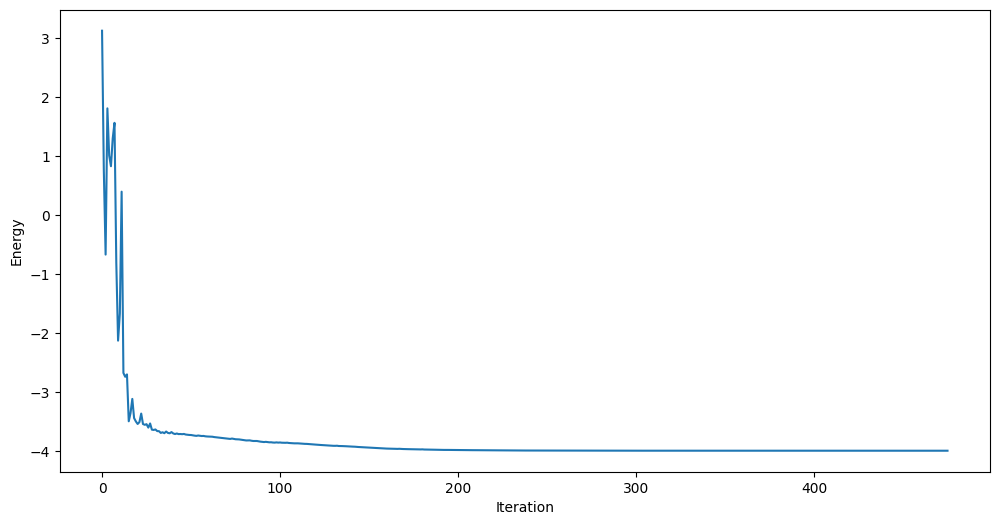

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(iter_energy)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

Result bitstring: [0, 1]


<BarContainer object of 4 artists>

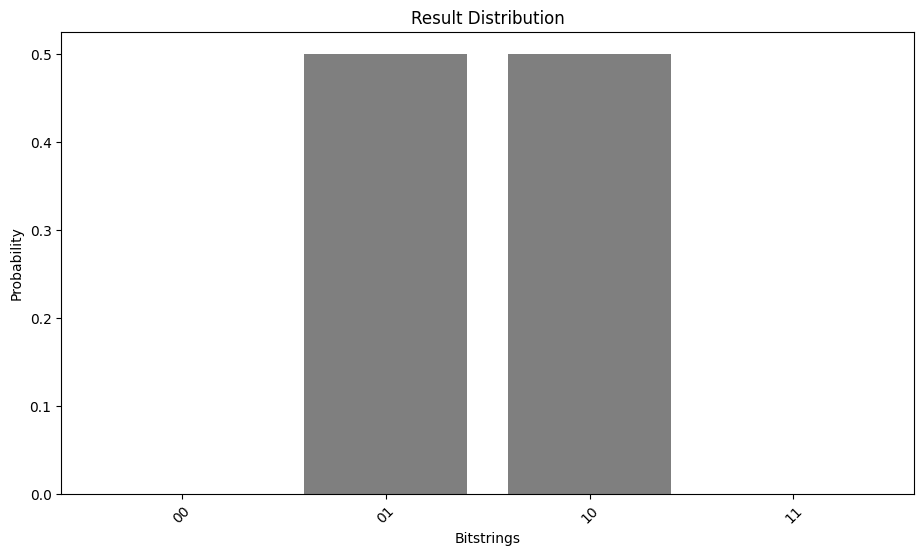

In [45]:
import matplotlib

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, n)

print("Result bitstring:", most_likely_bitstring)

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
positions = []
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")